In [ ]:
import numpy as np

def main():
    gridPoints = 51          # точки от 0 до 1 включительно
    xLeft = 0.0
    xRight = 1.0
    kMode = 1                # k в sin(pi * k * x)

    totalTime = 1         # до какого времени считаем
    timeSteps = 20         # количество шагов по времени

    h = (xRight - xLeft) / (gridPoints - 1)
    tau = totalTime / timeSteps

    print("h =", h)
    print("tau =", tau)
    print("tau / h^2 =", tau / (h * h))
    print()

    xGrid = np.linspace(xLeft, xRight, gridPoints)

    # u^0(x) = sin(pi * k * x)
    u0 = np.sin(np.pi * kMode * xGrid)


    print("Начальное условие, первые несколько значений:")
    print(u0[:10])
    print()

    # матрица оператора второй производной (внутренние точки)
    # L u ≈ (u_{m+1} - 2 u_m + u_{m-1}) / h^2
    # размер (N-2) x (N-2), без граничных точек
    L = buildLaplacianMatrix(gridPoints, h)

    # схема 1 (плохая)
    runBadScheme(xGrid, u0.copy(), L, tau, timeSteps)

    # схема 2 (модифицированная)
    alphaValue = 0.05   
    runGoodScheme(xGrid, u0.copy(), L, tau, timeSteps, alphaValue)


def buildLaplacianMatrix(gridPoints, h):
    # всего узлов gridPoints, но внутренние точки - это без 0 и N-1
    innerPoints = gridPoints - 2

    laplacianMatrix = np.zeros((innerPoints, innerPoints))

    for i in range(innerPoints):
        laplacianMatrix[i, i] = -2.0 / (h * h)
        if i > 0:
            laplacianMatrix[i, i - 1] = 1.0 / (h * h)
        if i < innerPoints - 1:
            laplacianMatrix[i, i + 1] = 1.0 / (h * h)

    return laplacianMatrix


def runBadScheme(xGrid, uFull, L, tau, timeSteps):
    # uFull содержит значения во всех точках, включая границы
    # внутренние точки (индексы 1..N-2) будем хранить в отдельном векторе
    gridPoints = len(xGrid)
    innerPoints = gridPoints - 2

    # вырезаем внутренние значения
    uInner = uFull[1:-1]

    # матрица слева: (I + tau * L)
    identityMatrix = np.eye(innerPoints)
    leftMatrix = identityMatrix + tau * L

    # заранее считаю обратную матрицу (так проще, как начинающий программист)
    # хотя для реальных задач лучше использовать solve каждый шаг
    leftMatrixInv = np.linalg.inv(leftMatrix)

    for n in range(timeSteps):
        currentTime = (n + 1) * tau

        # решаем (I + tau L) u^{n+1} = u^n
        uInner = leftMatrixInv.dot(uInner)

        #  границы у нас 0
        uFull[1:-1] = uInner
        uFull[0] = 0.0
        uFull[-1] = 0.0

        # считаю максимум по модулю, чтобы посмотреть рост
        maxAbsValue = np.max(np.abs(uFull))

        if (n + 1) % 20 == 0 or n == 0:
            print("Шаг времени:", n + 1, " t =", round(currentTime, 4))
            print("  max|u| =", maxAbsValue)
            print("  первые 5 значений u:", uFull[:5])
            print("  последние 5 значений u:", uFull[-5:])
            print()

    print("ИТОГ ДЛЯ СХЕМЫ 1:")
    print("  финальный max|u| =", np.max(np.abs(uFull)))
    print("  видно, что значения растут (схема неустойчивая или очень плохая).")


def runGoodScheme(xGrid, uFull, L, tau, timeSteps, alphaValue):
    gridPoints = len(xGrid)
    innerPoints = gridPoints - 2

    uInner = uFull[1:-1]

    identityMatrix = np.eye(innerPoints)

    # матрица слева: (I - alpha * L)
    leftMatrix = identityMatrix - alphaValue * L

    # матрица справа: (I - (tau + alpha) * L)
    rightMatrix = identityMatrix - (tau + alphaValue) * L

    # снова считаю обратную слева 
    leftMatrixInv = np.linalg.inv(leftMatrix)

    for n in range(timeSteps):
        currentTime = (n + 1) * tau

        # считаю правую часть
        rightVector = rightMatrix.dot(uInner)

        # решаю (I - alpha L) u^{n+1} = (I - (tau + alpha)L) u^n
        uInner = leftMatrixInv.dot(rightVector)

        # собираю полный вектор
        uFull[1:-1] = uInner
        uFull[0] = 0.0
        uFull[-1] = 0.0

        maxAbsValue = np.max(np.abs(uFull))

        if (n + 1) % 20 == 0 or n == 0:
            print("Шаг времени:", n + 1, " t =", round(currentTime, 4))
            print("  max|u| =", maxAbsValue)
            print("  первые 5 значений u:", uFull[:5])
            print("  последние 5 значений u:", uFull[-5:])
            print()

    print("ИТОГ ДЛЯ СХЕМЫ 2:")
    print("  финальный max|u| =", np.max(np.abs(uFull)))


if __name__ == "__main__":
    main()


h = 0.02
tau = 0.05
tau / h^2 = 125.0

Начальное условие, первые несколько значений:
[0.         0.06279052 0.12533323 0.18738131 0.24868989 0.30901699
 0.36812455 0.42577929 0.48175367 0.53582679]

===== СХЕМА 1: (u^{n+1} - u^n)/tau = - L u^{n+1} =====
Шаг времени: 1  t = 0.05
  max|u| = 1.9736240653669115
  первые 5 значений u: [0.         0.12392488 0.24736069 0.36982027 0.49082035]
  последние 5 значений u: [0.49082035 0.36982027 0.24736069 0.12392488 0.        ]

Шаг времени: 20  t = 1.0
  max|u| = 804060.3406971619
  первые 5 значений u: [     0.          50487.36652529 100775.48248039 150665.88364608
 199961.67540171]
  последние 5 значений u: [199961.67540171 150665.88364608 100775.48248039  50487.36652529
      0.        ]

ИТОГ ДЛЯ СХЕМЫ 1:
  финальный max|u| = 804060.3406971619
  видно, что значения растут (схема неустойчивая или очень плохая).

===== СХЕМА 2: модифицированная с параметром alpha =====
Шаг времени: 1  t = 0.05
  max|u| = 1.330350218976804
  первые 5 значений 

h = 0.05263157894736842
tau = 0.006666666666666667
tau / h^2 = 2.406666666666667



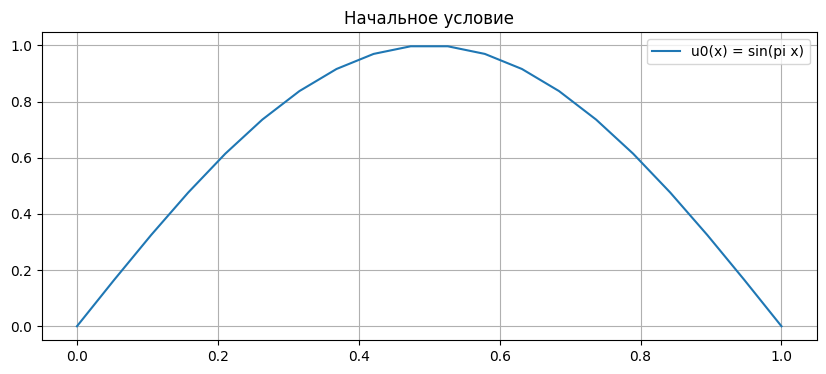

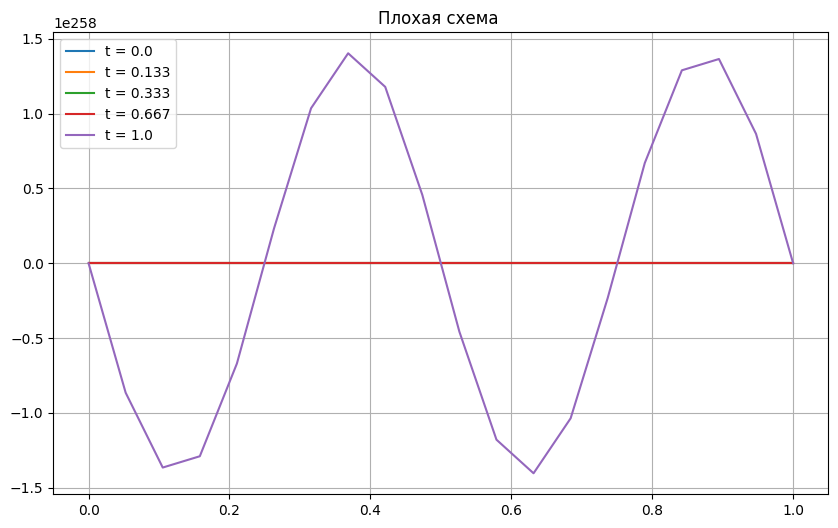

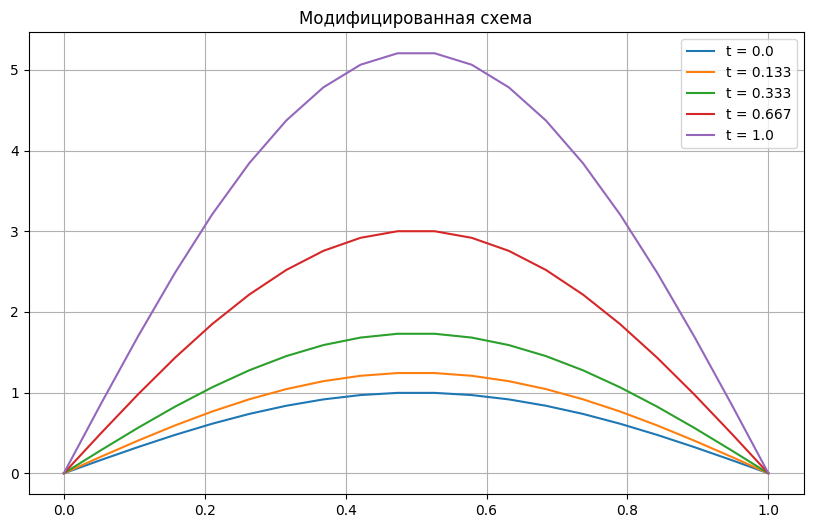

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    # параметры сетки
    gridPoints = 20
    xLeft = 0.0
    xRight = 1.0
    kMode = 1

    totalTime = 1.0
    timeSteps = 150    

    # шаги сетки
    h = (xRight - xLeft) / (gridPoints - 1)
    tau = totalTime / timeSteps

    print("h =", h)
    print("tau =", tau)
    print("tau / h^2 =", tau / (h * h))
    print()

    # сетка и начальное условие
    xGrid = np.linspace(xLeft, xRight, gridPoints)
    u0 = np.sin(np.pi * kMode * xGrid)

    L = buildLaplacianMatrix(gridPoints, h)

    # временные точки для графиков
    timePoints = [0, 20, 50, 100, 150, 200]

    badSnapshots = []
    goodSnapshots = []

    # ПЛОХАЯ СХЕМА

    uBad = u0.copy()
    uBadInner = uBad[1:-1]
    N = gridPoints - 2

    I = np.eye(N)
    leftMatrix = I + tau * L
    leftInv = np.linalg.inv(leftMatrix)

    for n in range(timeSteps + 1):
        if n in timePoints:
            badSnapshots.append(uBad.copy())

        if n < timeSteps:
            uBadInner = leftInv.dot(uBadInner)
            uBad[1:-1] = uBadInner

    # МОДИФИЦИРОВАННАЯ СХЕМА
    alphaValue = 0.5
    uGood = u0.copy()
    uGoodInner = uGood[1:-1]

    leftMatrixG = I - alphaValue * L
    rightMatrixG = I - (tau + alphaValue) * L
    leftInvG = np.linalg.inv(leftMatrixG)

    for n in range(timeSteps + 1):
        if n in timePoints:
            goodSnapshots.append(uGood.copy())

        if n < timeSteps:
            rhs = rightMatrixG.dot(uGoodInner)
            uGoodInner = leftInvG.dot(rhs)
            uGood[1:-1] = uGoodInner



    # начальное условие
    plt.figure(figsize=(10, 4))
    plt.plot(xGrid, u0, label="u0(x) = sin(pi x)")
    plt.grid()
    plt.title("Начальное условие")
    plt.legend()

    # плохая схема
    plt.figure(figsize=(10, 6))
    for tStep, snap in zip(timePoints, badSnapshots):
        t = round(tStep * tau, 3)
        plt.plot(xGrid, snap, label=f"t = {t}")
    plt.grid()
    plt.title("Плохая схема ")
    plt.legend()

    # хорошая схема
    plt.figure(figsize=(10, 6))
    for tStep, snap in zip(timePoints, goodSnapshots):
        t = round(tStep * tau, 3)
        plt.plot(xGrid, snap, label=f"t = {t}")
    plt.grid()
    plt.title("Модифицированная схема")
    plt.legend()

    plt.show()


def buildLaplacianMatrix(gridPoints, h):
    n = gridPoints - 2
    L = np.zeros((n, n))

    for i in range(n):
        L[i, i] = -2.0 / (h * h)
        if i > 0:
            L[i, i - 1] = 1.0 / (h * h)
        if i < n - 1:
            L[i, i + 1] = 1.0 / (h * h)

    return L


if __name__ == "__main__":
    main()



Лучший alpha = 0.0
L2-норма ошибки = nan


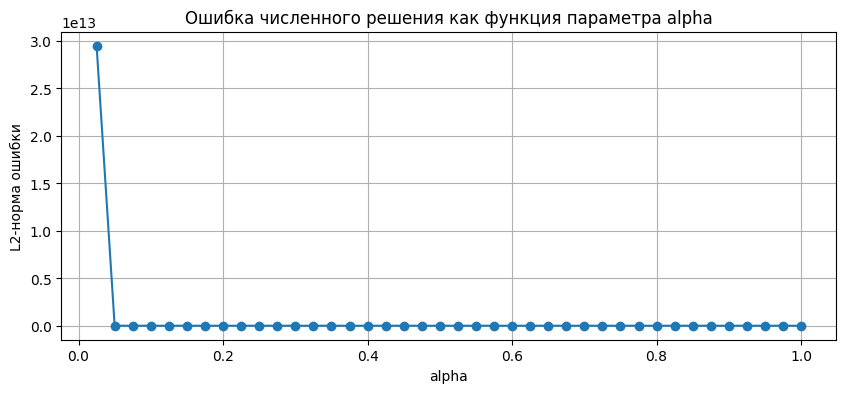

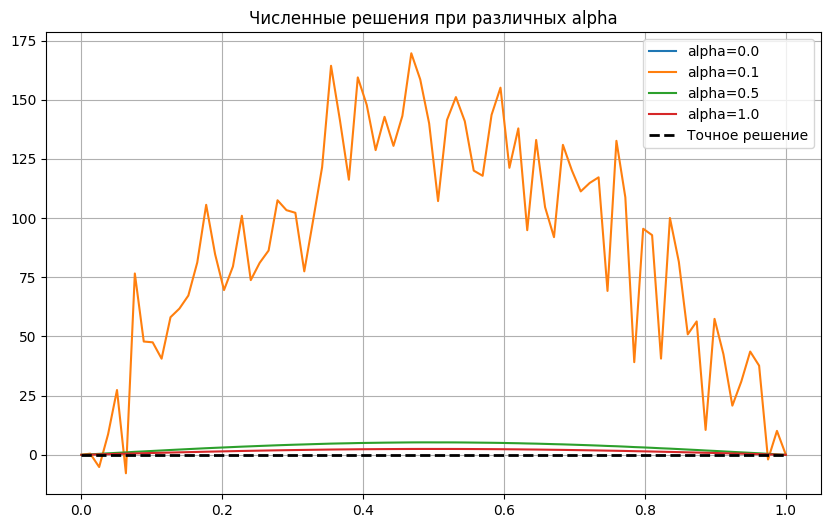

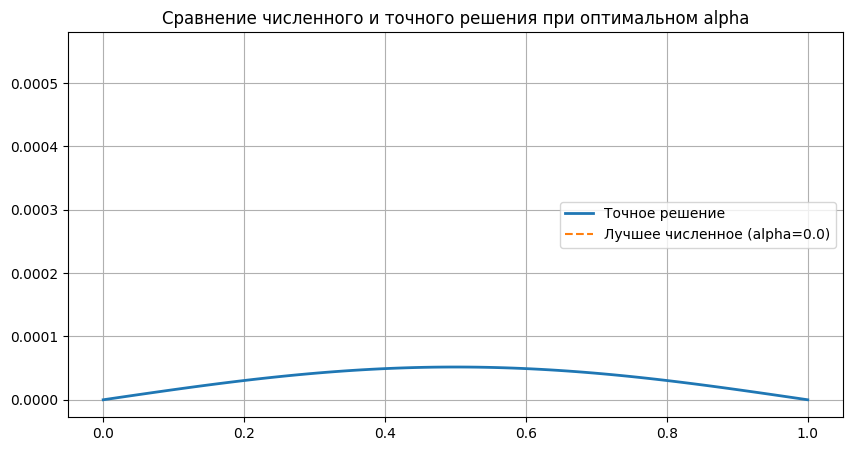

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    # параметры задачи
    gridPoints = 80
    xLeft = 0.0
    xRight = 1.0
    kMode = 1

    # параметры времени
    totalTime = 1.0
    timeSteps = 400

    # сетка
    h = (xRight - xLeft) / (gridPoints - 1)
    tau = totalTime / timeSteps
    xGrid = np.linspace(xLeft, xRight, gridPoints)

    # начальное условие
    u0 = np.sin(np.pi * kMode * xGrid)

    # добавим маленький шум — иначе α=0 будет оптимальным
    noiseLevel = 0.001
    u0_noisy = u0 + noiseLevel * np.random.randn(gridPoints)

    # правильное точное решение для u_t = -u_xx
    uExact = np.exp(-(np.pi * kMode)**2 * totalTime) * np.sin(np.pi * kMode * xGrid)

    # матрица второй производной
    L = buildLaplacianMatrix(gridPoints, h)
    N = gridPoints - 2
    I = np.eye(N)

    # перебор alpha ∈ [0, 1]
    alphaList = np.linspace(0.0, 1.0, 41)
    errorList = []
    solutionsForPlot = {}

    bestAlpha = None
    bestError = None
    bestSolution = None

    for alphaValue in alphaList:
        # матрицы модифицированной схемы
        A = I - alphaValue * L
        B = I - (tau + alphaValue) * L
        Ainv = np.linalg.inv(A)

        # стартовое решение
        uCurrent = u0_noisy.copy()
        uInner = uCurrent[1:-1].copy()

        # считаем по времени
        for n in range(timeSteps):
            rhs = B.dot(uInner)
            uInner = Ainv.dot(rhs)
            uCurrent[1:-1] = uInner

        # ошибка
        error = l2Norm(uCurrent - uExact, h)
        errorList.append(error)

        # сохраняем несколько alpha для графиков
        if alphaValue in [0.0, 0.1, 0.3, 0.5, 1.0]:
            solutionsForPlot[alphaValue] = uCurrent.copy()

        # ищем лучшую alpha
        if bestError is None or error < bestError:
            bestError = error
            bestAlpha = alphaValue
            bestSolution = uCurrent.copy()

    print("\nЛучший alpha =", bestAlpha)
    print("L2-норма ошибки =", bestError)

    # ---------------- ГРАФИК 1 ----------------
    plt.figure(figsize=(10, 4))
    plt.plot(alphaList, errorList, marker='o')
    plt.grid()
    plt.xlabel("alpha")
    plt.ylabel("L2-норма ошибки")
    plt.title("Ошибка численного решения как функция параметра alpha")

    # ---------------- ГРАФИК 2 ----------------
    plt.figure(figsize=(10, 6))
    for alpha, sol in solutionsForPlot.items():
        plt.plot(xGrid, sol, label=f"alpha={alpha}")
    plt.plot(xGrid, uExact, 'k--', linewidth=2, label="Точное решение")
    plt.title("Численные решения при различных alpha")
    plt.grid()
    plt.legend()

    # ---------------- ГРАФИК 3 ----------------
    plt.figure(figsize=(10, 5))
    plt.plot(xGrid, uExact, label="Точное решение", linewidth=2)
    plt.plot(xGrid, bestSolution, '--', label=f"Лучшее численное (alpha={bestAlpha})")
    plt.title("Сравнение численного и точного решения при оптимальном alpha")
    plt.grid()
    plt.legend()

    plt.show()


def buildLaplacianMatrix(gridPoints, h):
    n = gridPoints - 2
    L = np.zeros((n, n))
    for i in range(n):
        L[i, i] = -2.0 / (h*h)
        if i > 0:
            L[i, i-1] = 1.0 / (h*h)
        if i < n - 1:
            L[i, i+1] = 1.0 / (h*h)
    return L


def scalarProduct(u, v, h):
    u = u[1:-1]
    v = v[1:-1]
    return h * np.sum(u * v)


def l2Norm(u, h):
    return np.sqrt(scalarProduct(u, u, h))


if __name__ == "__main__":
    main()


=== ПАРАМЕТРЫ СЕТКИ ===
gridPoints = 20
h = 0.05263157894736842
tau = 0.01
tau / h^2 = 3.6100000000000008

=== ПОДБОР alpha ===
alpha = 0.000
  L2-ошибка = 1.545181e+00
alpha = 0.010
  L2-ошибка = 1.403734e+00
alpha = 0.020
  L2-ошибка = 1.293460e+00
alpha = 0.030
  L2-ошибка = 1.205262e+00
alpha = 0.040
  L2-ошибка = 1.133227e+00
alpha = 0.051
  L2-ошибка = 1.073353e+00
alpha = 0.061
  L2-ошибка = 1.022846e+00
alpha = 0.071
  L2-ошибка = 9.796960e-01
alpha = 0.081
  L2-ошибка = 9.424253e-01
alpha = 0.091
  L2-ошибка = 9.099229e-01
alpha = 0.101
  L2-ошибка = 8.813387e-01
alpha = 0.111
  L2-ошибка = 8.560117e-01
alpha = 0.121
  L2-ошибка = 8.334205e-01
alpha = 0.131
  L2-ошибка = 8.131485e-01
alpha = 0.141
  L2-ошибка = 7.948590e-01
alpha = 0.152
  L2-ошибка = 7.782771e-01
alpha = 0.162
  L2-ошибка = 7.631760e-01
alpha = 0.172
  L2-ошибка = 7.493673e-01
alpha = 0.182
  L2-ошибка = 7.366930e-01
alpha = 0.192
  L2-ошибка = 7.250197e-01
alpha = 0.202
  L2-ошибка = 7.142341e-01
alpha = 0.2

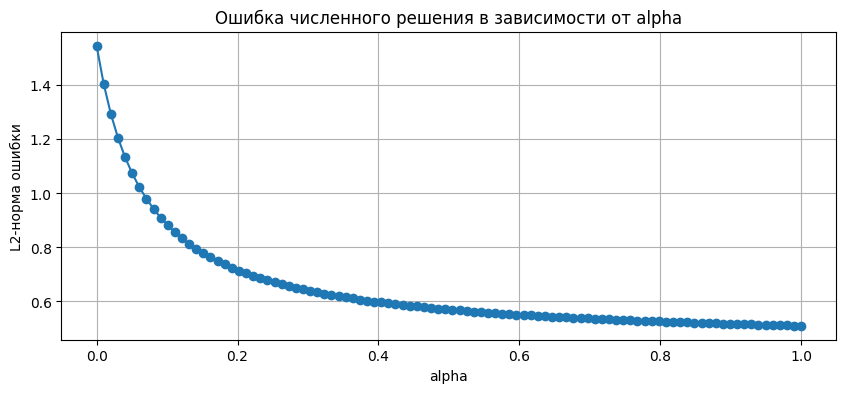

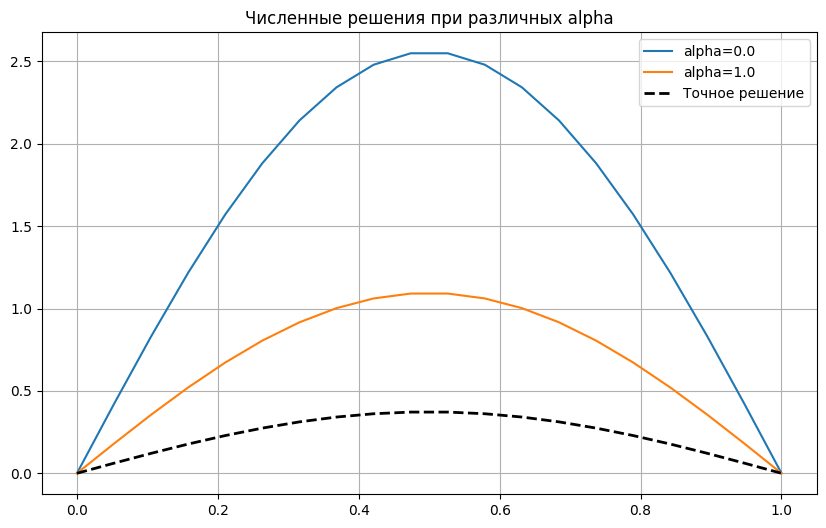

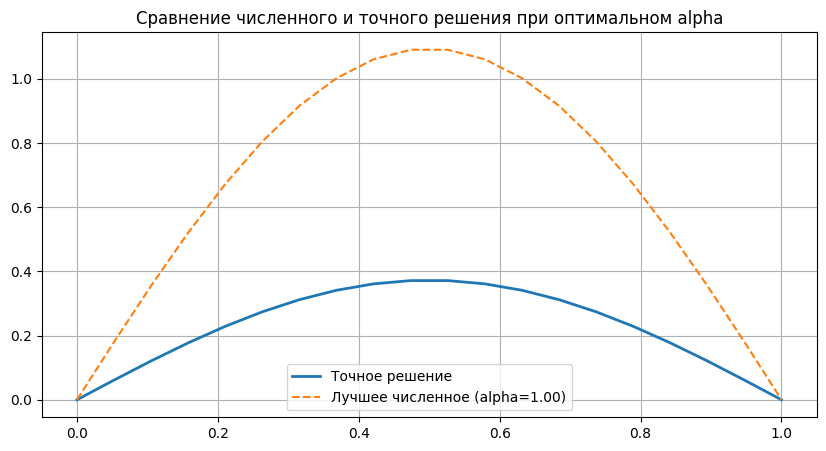

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    gridPoints = 20         # меньше точек, шаг по x крупнее
    xLeft = 0.0
    xRight = 1.0
    kMode = 1

    totalTime = 0.1         # считаем до T = 0.1
    timeSteps = 10          # мало шагов, шаг по t довольно крупный

    h = (xRight - xLeft) / (gridPoints - 1)
    tau = totalTime / timeSteps

    print("=== ПАРАМЕТРЫ СЕТКИ ===")
    print("gridPoints =", gridPoints)
    print("h =", h)
    print("tau =", tau)
    print("tau / h^2 =", tau / (h * h))
    print()

    # сетка по x
    xGrid = np.linspace(xLeft, xRight, gridPoints)

    # начальное условие u(x,0) = sin(pi k x)
    u0 = np.sin(np.pi * kMode * xGrid)

    # точное решение для уравнения u_t = -u_xx:
    # u(x,t) = exp(- (pi k)^2 * t) * sin(pi k x)
    uExact = np.exp(-(np.pi * kMode) ** 2 * totalTime) * np.sin(np.pi * kMode * xGrid)

    # матрица лапласиана для внутренних точек
    laplacianMatrix = buildLaplacianMatrix(gridPoints, h)
    innerPoints = gridPoints - 2
    identityMatrix = np.eye(innerPoints)

    # перебираем alpha от 0 до 1 (включая 0, чтобы увидеть, что она плохая)
    alphaList = np.linspace(0.0, 1.0, 100)   # 0.00, 0.02, ..., 1.00
    errorList = []

    bestAlpha = None
    bestError = None
    bestUNum = None

    # для красивого графика решений при нескольких alpha
    solutionsForPlot = {}

    print("=== ПОДБОР alpha ===")
    for alphaValue in alphaList:
        print(f"alpha = {alphaValue:.3f}")

        # матрицы модифицированной схемы:
        # (I - alpha L) u^{n+1} = (I - (tau + alpha) L) u^n
        leftMatrix = identityMatrix - alphaValue * laplacianMatrix
        rightMatrix = identityMatrix - (tau + alphaValue) * laplacianMatrix

        # обратная матрица слева
        leftMatrixInv = np.linalg.inv(leftMatrix)

        # текущее численное решение, стартуем с u0
        uCurrent = u0.copy()
        uInner = uCurrent[1:-1].copy()

        for n in range(timeSteps):
            # правая часть (I - (tau + alpha)L) u^n
            rightVector = rightMatrix.dot(uInner)
            # решаем (I - alpha L) u^{n+1} = ...
            uInner = leftMatrixInv.dot(rightVector)
            # записываем обратно
            uCurrent[1:-1] = uInner

        errorVector = uCurrent - uExact
        l2Error = l2Norm(errorVector, h)
        errorList.append(l2Error)

        print(f"  L2-ошибка = {l2Error:.6e}")

        if abs(alphaValue - 0.0) < 1e-12 or abs(alphaValue - 0.1) < 1e-12 \
           or abs(alphaValue - 0.3) < 1e-12 or abs(alphaValue - 0.5) < 1e-12 \
           or abs(alphaValue - 1.0) < 1e-12:
            solutionsForPlot[alphaValue] = uCurrent.copy()

        if bestError is None or l2Error < bestError:
            bestError = l2Error
            bestAlpha = alphaValue
            bestUNum = uCurrent.copy()

    print()
    print("Лучший alpha =", bestAlpha)
    print("Минимальная L2-ошибка =", bestError)
    print()

    # --------- ГРАФИК 1: ошибка(α) ---------
    plt.figure(figsize=(10, 4))
    plt.plot(alphaList, errorList, marker='o')
    plt.grid()
    plt.xlabel("alpha")
    plt.ylabel("L2-норма ошибки")
    plt.title("Ошибка численного решения в зависимости от alpha")

    # --------- ГРАФИК 2: разные alpha ---------
    plt.figure(figsize=(10, 6))
    for alphaVal, sol in solutionsForPlot.items():
        plt.plot(xGrid, sol, label=f"alpha={alphaVal}")
    plt.plot(xGrid, uExact, 'k--', linewidth=2, label="Точное решение")
    plt.grid()
    plt.legend()
    plt.title("Численные решения при различных alpha")

    # --------- ГРАФИК 3: лучший alpha ---------
    plt.figure(figsize=(10, 5))
    plt.plot(xGrid, uExact, label="Точное решение", linewidth=2)
    plt.plot(xGrid, bestUNum, '--', label=f"Лучшее численное (alpha={bestAlpha:.2f})")
    plt.grid()
    plt.legend()
    plt.title("Сравнение численного и точного решения при оптимальном alpha")

    plt.show()


def buildLaplacianMatrix(gridPoints, h):
    # матрица дискретного оператора u_xx для внутренних точек
    n = gridPoints - 2
    laplacianMatrix = np.zeros((n, n))

    for i in range(n):
        laplacianMatrix[i, i] = -2.0 / (h * h)
        if i > 0:
            laplacianMatrix[i, i - 1] = 1.0 / (h * h)
        if i < n - 1:
            laplacianMatrix[i, i + 1] = 1.0 / (h * h)

    return laplacianMatrix


def scalarProduct(uVector, vVector, h):
    # скалярное произведение (u, v)_h = sum u_i v_i * h
    #  только внутренние узлы
    uInner = uVector[1:-1]
    vInner = vVector[1:-1]
    return h * np.sum(uInner * vInner)


def l2Norm(uVector, h):
    # L2-норма через скалярное произведение
    return np.sqrt(scalarProduct(uVector, uVector, h))


if __name__ == "__main__":
    main()


h = 0.05263157894736842
tau = 0.01
tau/h^2 = 3.6100000000000008

Лучший alpha = 10.0
Минимальная ошибка = 0.4505937880003063


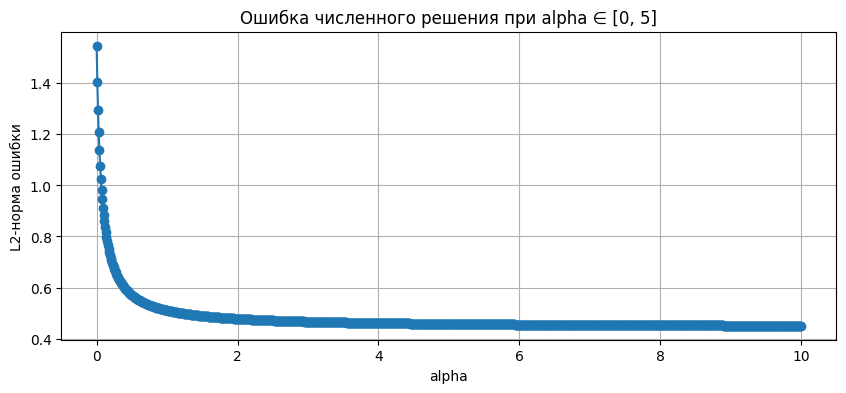

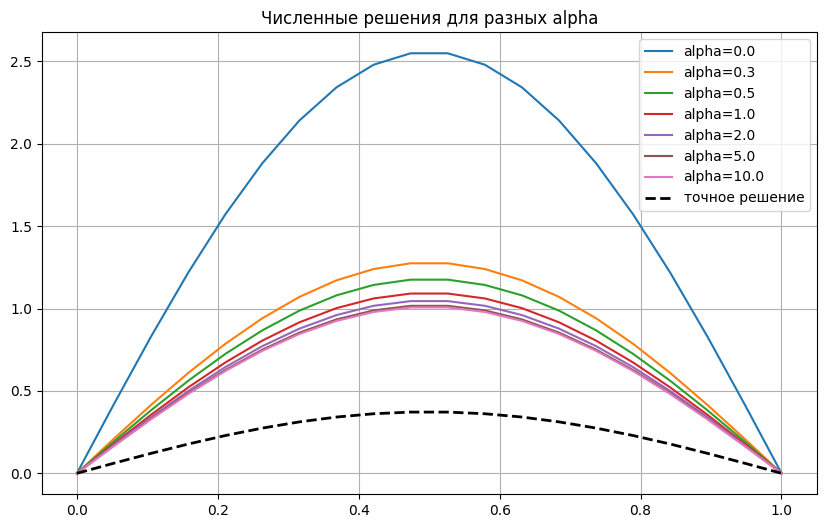

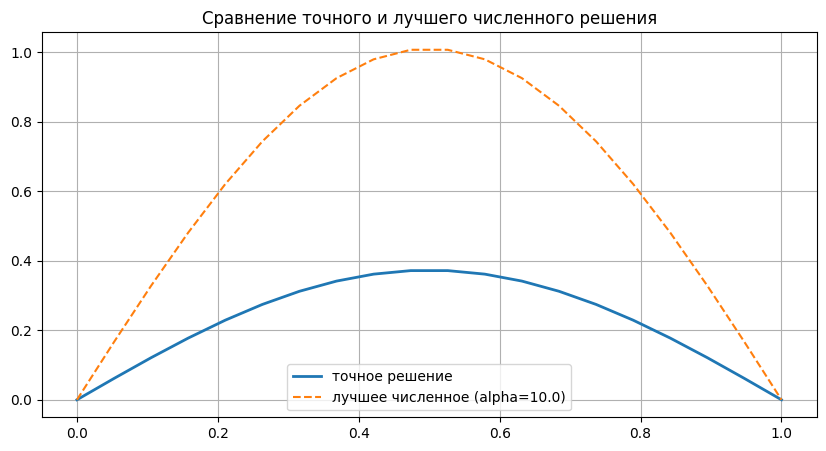

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    gridPoints = 20
    xLeft = 0.0
    xRight = 1.0
    kMode = 1

    totalTime = 0.1
    timeSteps = 10

    h = (xRight - xLeft) / (gridPoints - 1)
    tau = totalTime / timeSteps
    xGrid = np.linspace(xLeft, xRight, gridPoints)

    print("h =", h)
    print("tau =", tau)
    print("tau/h^2 =", tau/(h*h))
    print()

    u0 = np.sin(np.pi * kMode * xGrid)

    uExact = np.exp(-(np.pi * kMode)**2 * totalTime) * np.sin(np.pi * kMode * xGrid)

    L = buildLaplacianMatrix(gridPoints, h)
    N = gridPoints - 2
    I = np.eye(N)

    alphaList = np.linspace(0, 10, 1001)   # <-- α от 0 до 5
    errorList = []

    bestAlpha = None
    bestError = None
    bestSolution = None

    solutionsForPlot = {}

    for alphaValue in alphaList:
        A = I - alphaValue * L
        B = I - (tau + alphaValue) * L
        Ainv = np.linalg.inv(A)

        uCurrent = u0.copy()
        uInner = uCurrent[1:-1].copy()

        # шаги по времени
        for n in range(timeSteps):
            rhs = B.dot(uInner)
            uInner = Ainv.dot(rhs)
            uCurrent[1:-1] = uInner

        # ошибка
        error = l2Norm(uCurrent - uExact, h)
        errorList.append(error)

        if alphaValue in [0.0, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
            solutionsForPlot[alphaValue] = uCurrent.copy()

        # лучший alpha
        if bestError is None or error < bestError:
            bestError = error
            bestAlpha = alphaValue
            bestSolution = uCurrent.copy()

    print("Лучший alpha =", bestAlpha)
    print("Минимальная ошибка =", bestError)

    # график ошибки
    plt.figure(figsize=(10, 4))
    plt.plot(alphaList, errorList, marker='o')
    plt.grid()
    plt.xlabel("alpha")
    plt.ylabel("L2-норма ошибки")
    plt.title("Ошибка численного решения при alpha ∈ [0, 5]")

    # графики решений
    plt.figure(figsize=(10, 6))
    for a, sol in solutionsForPlot.items():
        plt.plot(xGrid, sol, label=f"alpha={a}")
    plt.plot(xGrid, uExact, 'k--', linewidth=2, label="точное решение")
    plt.legend()
    plt.grid()
    plt.title("Численные решения для разных alpha")

    # лучший alpha
    plt.figure(figsize=(10, 5))
    plt.plot(xGrid, uExact, label="точное решение", linewidth=2)
    plt.plot(xGrid, bestSolution, '--', label=f"лучшее численное (alpha={bestAlpha})")
    plt.legend()
    plt.grid()
    plt.title("Сравнение точного и лучшего численного решения")

    plt.show()


def buildLaplacianMatrix(gridPoints, h):
    n = gridPoints - 2
    L = np.zeros((n, n))
    for i in range(n):
        L[i, i] = -2.0 / (h*h)
        if i > 0:
            L[i, i-1] = 1.0 / (h*h)
        if i < n - 1:
            L[i, i+1] = 1.0 / (h*h)
    return L


def scalarProduct(u, v, h):
    return h * np.sum(u[1:-1] * v[1:-1])


def l2Norm(u, h):
    return np.sqrt(scalarProduct(u, u, h))


if __name__ == "__main__":
    main()
